In [ ]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))
SEED = 0
## https://datasetsearch.research.google.com/search?query=amazon%20reviews%20dataset%20polarity&docid=p7MRKNwJKo4PvhOzAAAAAA%3D%3D
import random
random.seed(SEED)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

     |████████████████████████████████| 133kB 7.4MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
## download the dataset for analysis
!wget --no-check-certificate \
    'https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz' \
    -O './amazon_review_polarity_csv.tgz'

!tar -xzvf './amazon_review_polarity_csv.tgz'

--2020-12-13 08:46:15--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.107.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.107.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688339454 (656M) [application/x-tar]
Saving to: ‘./amazon_review_polarity_csv.tgz’

./amazon_review_pol 100%[===================>] 656.45M  52.8MB/s    in 12s     

2020-12-13 08:46:27 (52.8 MB/s) - ‘./amazon_review_polarity_csv.tgz’ saved [688339454/688339454]

amazon_review_polarity_csv/
amazon_review_polarity_csv/train.csv
amazon_review_polarity_csv/readme.txt
amazon_review_polarity_csv/test.csv


In [ ]:
# read the dataset, name the columns and add one column for predicted sentiment
%%time
train = pd.read_csv('amazon_review_polarity_csv/train.csv', header=None)
test = pd.read_csv('amazon_review_polarity_csv/test.csv', header=None)

train.columns = ['label', 'review_title', 'review_text']
test.columns = ['label', 'review_title', 'review_text']

train.loc[:, 'sentiment_predicted'] = None
test.loc[:, 'sentiment_predicted'] = None

print(f'Train shape: {train.shape} - Test shape: {test.shape}')

train.drop(['review_title'], axis=1, inplace=True)
test.drop(['review_title'], axis=1, inplace=True)

Train shape: (3600000, 4) - Test shape: (400000, 4)
CPU times: user 20.9 s, sys: 2.14 s, total: 23 s
Wall time: 23 s


In [ ]:
train.head(10)

,label,review_text,sentiment_predicted
0,2,This sound track was beautiful! It paints the ...,None
1,2,I'm reading a lot of reviews saying that this ...,None
2,2,This soundtrack is my favorite music of all ti...,None
3,2,I truly like this soundtrack and I enjoy video...,None
4,2,"If you've played the game, you know how divine...",None
5,2,I am quite sure any of you actually taking the...,None
6,1,"This is a self-published book, and if you want...",None
7,2,I loved Whisper of the wicked saints. The stor...,None
8,2,I just finished reading Whisper of the Wicked ...,None
9,2,This was a easy to read book that made me want...,None


In [ ]:
## showcase a negative text (the seventh row)
train.iloc[6]["review_text"]

'This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon\'s family and friends--or perhaps, by herself! I can\'t imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can\'t believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on "To Kill a Mockingbird"--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!'

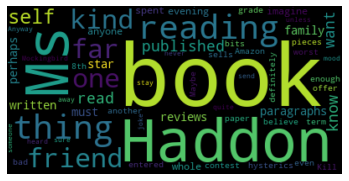

In [ ]:
wordcloud = WordCloud().generate(train.iloc[6]["review_text"])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

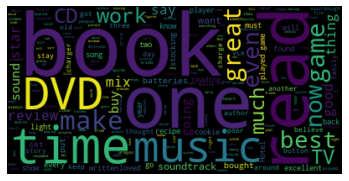

In [ ]:
text = ""
for i in range(50):#len(train)):
  text += ".\n" + train.iloc[i]["review_text"]

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
Y_train = train['label'].values
X_train = train['review_text'].values

Y_test = test['label'].values
X_test = test['review_text'].values

In [ ]:
%%time
unigram_count = CountVectorizer(stop_words="english")

X_train_vec = unigram_count.fit_transform(X_train)
X_test_vec = unigram_count.transform(X_test)

print(len(unigram_count.vocabulary_))

936809
CPU times: user 3min 17s, sys: 1.79 s, total: 3min 18s
Wall time: 3min 19s


In [ ]:
%%time

# initialize MNB model
mnb = MultinomialNB()

# train the model
mnb.fit(X_train_vec, Y_train)

score 0.8205925
CPU times: user 2.09 s, sys: 22.8 ms, total: 2.11 s
Wall time: 2.11 s


In [ ]:
%%time

y_pred= mnb.fit(X_train_vec, Y_train).predict(X_test_vec)
cm = confusion_matrix(Y_test[:50000],y_pred[:50000])
print(cm)

[[20020  4606]
 [ 4268 21106]]
CPU times: user 2.08 s, sys: 9.76 ms, total: 2.09 s
Wall time: 2.09 s


In [ ]:
print(precision_score(Y_test[:50000],y_pred[:50000]))
print(recall_score(Y_test[:50000],y_pred[:50000]))
print(accuracy_score(Y_test[:50000],y_pred[:50000]))

0.8242753623188406
0.8129619101762365
0.82252


MNB Model:

[
  
  [20020  4606]
 
 [ 4268 21106]
 
 ]

Precision:  0.82427

Recall:     0.81296

Accuracy:   0.82252